In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="ticks", context="paper", font_scale=1)
np.random.seed(0)

Text(0.5, 1.0, 'True function')

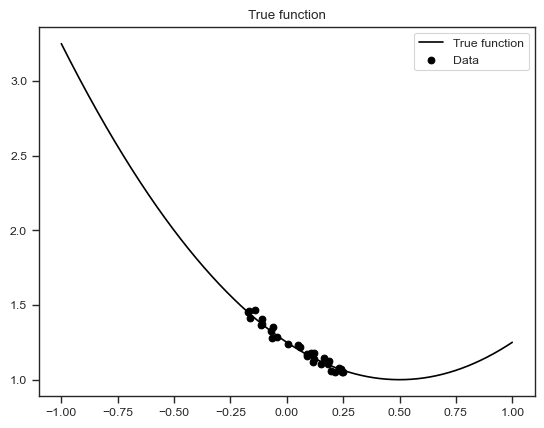

In [110]:
from utils import quadratic
from functools import partial
from scipy.stats import truncnorm

interval = [-1, 1]
precision = 1000
quadratic = partial(quadratic, m=0.5, a=1, b=1)
x = np.linspace(interval[0], interval[1], precision)
y = quadratic(x)
B = 5

n_data = 30
noise_sigma = 1 / 40


def create_dataset(n_data, noise_sigma, func=quadratic):
    x_data = np.random.uniform(interval[0] / 4, interval[1] / 4, n_data)
    y_mean = quadratic(x_data)
    lower, upper = (0 - y_mean) / noise_sigma, (B - y_mean) / noise_sigma
    noise = []
    for i in range(n_data):
        noise.append(truncnorm.rvs(lower[i], upper[i], loc=0, scale=noise_sigma))

    noise = np.array(noise).flatten()
    y_data = y_mean + noise
    assert np.all(y_data >= 0) and np.all(y_data <= B)
    return x_data, y_data


x_data, y_data = create_dataset(n_data, noise_sigma)


plt.plot(x, y, label="True function", color="black")
plt.scatter(x_data, y_data, label="Data", color="black")
plt.legend()
plt.title("True function")

In [124]:
# Prior parameters
n_basis = 100
prior_mu = np.random.uniform(0, 1, n_basis)
prior_mu = np.zeros(n_basis)
B_mu = np.random.uniform(0, 1) * B
prior_mu = prior_mu / np.sum(prior_mu) * B_mu
prior_sigma = np.eye(n_basis) * 1.0

/var/folders/2y/8rqh7kk566b1nf_453g9hx3w0000gn/T/ipykernel_53764/3778564604.py:6: RuntimeWarning: invalid value encountered in divide
  prior_mu = prior_mu / np.sum(prior_mu) * B_mu


In [103]:
# First sampling algorithm:


def sample_1(
    prior_mu, prior_sigma, noise_sigma, x_data, y_data, burn_in=500, num_samples=5
):
    len_features = len(prior_mu)
    base = np.linspace(interval[0], interval[1], len_features)
    # X = np.array([np.abs(x - base) for x in x_data])  # Each row is a feature vector
    # inv_prior_sigma = np.linalg.inv(prior_sigma)
    # Phi = inv_prior_sigma + (X.T @ X) / noise_sigma**2
    # cov = np.linalg.inv(Phi)
    # mean = cov @ (inv_prior_sigma @ prior_mu + (Phi.T @ y_data) / (noise_sigma**2))

    Phi = np.array([np.abs(x - base) for x in x_data])
    Sigma_inv = np.linalg.inv(prior_sigma)
    post_cov_inv = Sigma_inv + (Phi.T @ Phi) / (noise_sigma**2)
    cov = np.linalg.inv(post_cov_inv)
    mean = cov @ (Sigma_inv @ prior_mu + (Phi.T @ y_data) / (noise_sigma**2))

    d = len_features
    init = np.copy(mean)  # set the initial point
    init[init <= 0] = 1e-3
    if np.sum(init) > B:
        init = init * (B / np.sum(init))

    samples = []
    total_iters = burn_in + num_samples
    current_param = np.copy(init)
    for it in range(total_iters):

        # Sample from the conditional distribution at coordinate i
        i = np.random.randint(d)
        m_cond, cov_cond = None, None
        other_idx = [j for j in range(d) if j != i]
        Sigma_ii = cov[i, i]
        Sigma_i_other = cov[i, other_idx]
        Sigma_other_other = cov[np.ix_(other_idx, other_idx)]
        mean_i = mean[i]
        mean_other = mean[other_idx]
        inv_Sigma_other_other = np.linalg.inv(Sigma_other_other)
        m_cond = mean_i + Sigma_i_other @ inv_Sigma_other_other @ (
            current_param[other_idx] - mean_other
        )
        cov_cond = Sigma_ii - Sigma_i_other @ inv_Sigma_other_other @ Sigma_i_other.T

        sd_cond = np.sqrt(cov_cond)
        sum_others = np.sum(np.delete(current_param, i))
        lower = 0.0
        upper = B - sum_others
        if upper < lower:  # safeguard
            upper = lower
        a, b = (lower - m_cond) / sd_cond, (upper - m_cond) / sd_cond
        current_param[i] = truncnorm.rvs(a, b, loc=m_cond, scale=sd_cond)

        if it >= burn_in:
            samples.append(np.copy(current_param))

    return np.array(samples)

In [ ]:
n_data = 0
noise_sigma = 1 / 40

x_data, y_data = create_dataset(n_data, noise_sigma)

samples = sample_1(
    prior_mu, prior_sigma, noise_sigma, x_data, y_data, burn_in=500, num_samples=5
)


def phi(x, t):
    """Basis function: |x - t|."""
    return np.abs(x - t)


def f(x, w, interval):
    ts = np.linspace(interval[0], interval[1], len(w))
    x = np.atleast_1d(x)
    return np.sum(np.array([phi(x, t) for t in ts]).T * w, axis=1)


base = np.linspace(interval[0], interval[1], n_basis)
for sample in samples:
    ys = f(base, sample, interval)
    kwargs = {
        # "alpha": np.exp(0.01 * (i - 100)),
        "linestyle": ":",
        "color": "black",
    }
    kwargs = kwargs | {"label": "TS-Sampled Functions"} if i == 0 else kwargs
    plt.plot(base, ys, **kwargs)

# plot the true function
plt.plot(x, y, label="True function", color="black")
plt.scatter(x_data, y_data, label="Data", color="black")
plt.legend()

ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.truncnorm` documentation for details.